# Title

## 1 The Business Analytical Question

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?". **This question was chosen because....**

### Frame the problem

How will Airbnb benefit from the model?

If we can ascertain the features that contribute to the "success" of a listing (represented by whether or not it receives reviews), we can direct marketing energy towards potential hosts who are more likely to succeed.

### Previous attempts at the problem



## 2.1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported.

In [88]:
# import libraries

from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, recall_score

In [2]:
airbnb = pd.read_csv('data/AB_NYC_2019.csv')

airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
num_listings = len(airbnb)
num_hosts = len(airbnb['host_id'].unique())

print(f'The data contains information about {num_listings} AirBnB listings from {num_hosts} hosts')

The data contains information about 48895 AirBnB listings from 37457 hosts


## Missing values

In [4]:
# check for missing values

airbnb.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the presence of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Therefore we can safely drop the columns `id`, `name`, `host_id`, and `host_name`, which will in turn address the missing values in `name` and `host_name`.

In [5]:
airbnb = airbnb.drop(columns= ['id', 'name', 'host_id', 'host_name'])
airbnb.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

<AxesSubplot:ylabel='Density'>

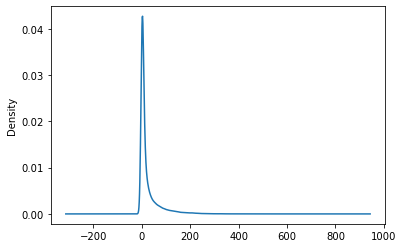

In [6]:
airbnb['number_of_reviews'].plot(kind = 'density')

Let's investigate these missing values for `last review` and `reviews_per_month`

In [7]:
airbnb[airbnb['last_review'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [8]:
airbnb[airbnb['reviews_per_month'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [9]:
len(airbnb[airbnb['number_of_reviews']==0])

10052

The missing values correspond to rows where there are no reviews. In these cases there is no date of last review because there have been no reviews, and `reviews_per_month` cannot be calculated.

Therefore we can fill the missing values with 0. It won't make a difference, however, as `reviews_per_month` and `last_review` are so strongly correlated with `number of reviews` that we will not be using them as features in the model.

In [10]:
airbnb.fillna(0, inplace = True)
airbnb.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [11]:
airbnb.drop(columns = ['last_review', 'reviews_per_month'], inplace = True)
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Split training and test data

At this point we should separate our training data from our test data. We will note all of the steps we perform on the training data and repeat them on the test data. This prevents information leakage from the test set **(CITE)**.


In [66]:
raw_train, raw_test = train_test_split(airbnb, random_state = 42, test_size = 0.2)
raw_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
32645,Brooklyn,Williamsburg,40.71577,-73.95530,Entire home/apt,295,3,11,1,1
23615,Manhattan,Washington Heights,40.84917,-73.94048,Private room,70,2,2,1,0
31183,Brooklyn,Bedford-Stuyvesant,40.68993,-73.95947,Private room,58,2,0,2,0
29260,Brooklyn,Bedford-Stuyvesant,40.68427,-73.93118,Entire home/apt,75,3,87,1,267
7275,Queens,Woodside,40.74705,-73.89564,Private room,38,5,13,1,0


### Encode the Target Variable

In [67]:
# Encode target variable as 0 (no reviews) or 1 (reviews)

def encode_target(df: pd.DataFrame) -> pd.DataFrame:
    feature_col = 'number_of_reviews'
    new_df = df.copy()
    new_df['has_reviews'] = df[feature_col].apply(lambda r: 0 if r == 0 else 1)
    return new_df.drop(columns = [feature_col])

# make a copy of the training data to explore and transform during EDA
raw_train = encode_target(raw_train)
raw_test = encode_target(raw_test)
eda_data = raw_train.copy()


### EDA

Next, examine the distribution of numeric features.

In [14]:
### Numerical attributes

numerical_data = eda_data.select_dtypes('number')
#sns.pairplot(numerical_data);

**comment on this**

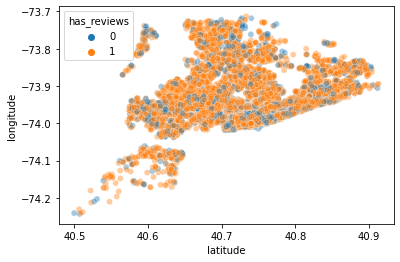

In [15]:
sns.scatterplot(data = eda_data, x = 'latitude', y = 'longitude', hue = 'has_reviews', alpha = 0.4);

In [16]:
def plot_distribution(df, col_of_interest, title = None):
    if title == None:
        title = "Distribution of "+ col_of_interest.replace('_', ' ') + " of AirBnB listings in New York City"
    #plt.title(title)
    #sns.kdeplot(data = df, x = col_of_interest, hue = 'has_reviews')
    #sns.rugplot(data = df, x = col_of_interest, color = 'lightgray')
    fig, ax = plt.subplots(figsize = (10,8))
    ax.set_title(title)
    df[df['has_reviews']==1][col_of_interest].plot(kind = 'density', ax = ax, label = 'has reviews')
    df[df['has_reviews']==0][col_of_interest].plot(kind = 'density', ax = ax, label = 'does not have reviews')
    ax.plot(df[col_of_interest], [-0.0001]*len(df[col_of_interest]), '|', color='k')
    ax.legend();

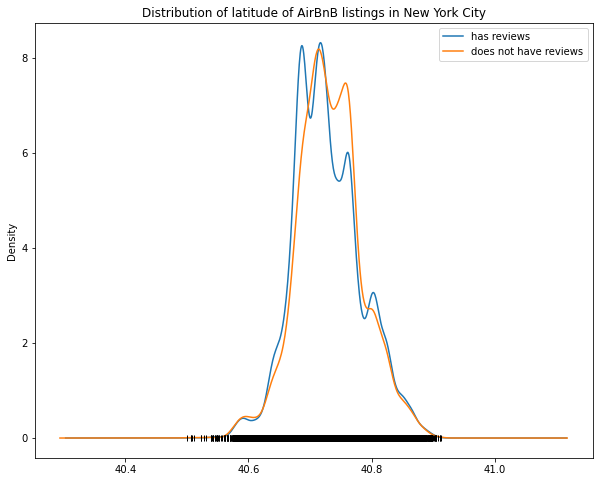

In [17]:
plot_distribution(eda_data, 'latitude')

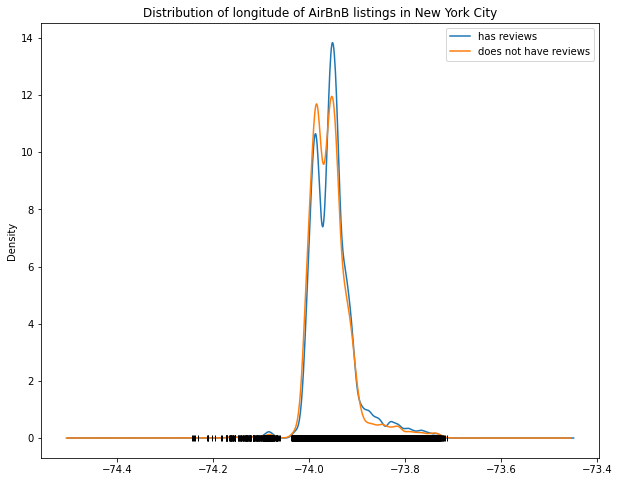

In [18]:
plot_distribution(eda_data, 'longitude')

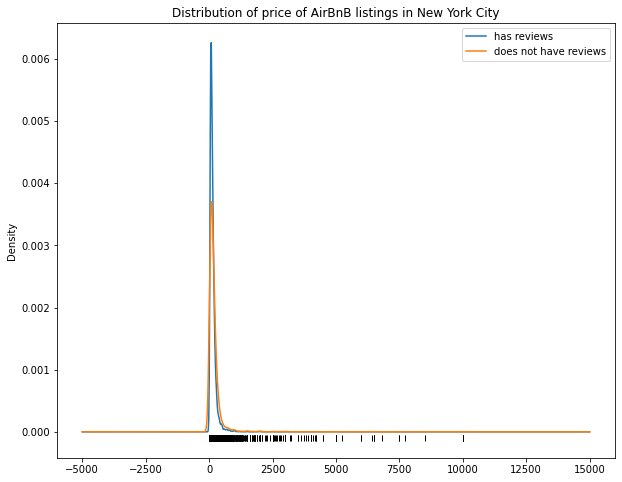

In [19]:
plot_distribution(eda_data, 'price')

The price distribution looks like it might be log normal. Transform it to get a normally distributed variable.

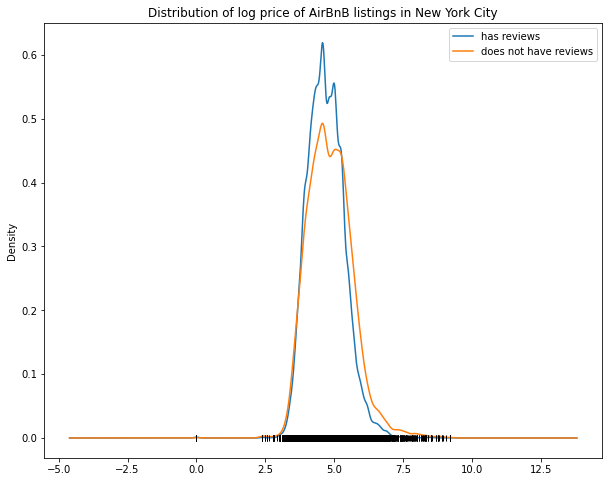

In [20]:
eda_data['log_price'] = eda_data['price'].apply(lambda p: np.log(p+1))
plot_distribution(eda_data, 'log_price')

The natural logarithm of price is approximately normally distributed.

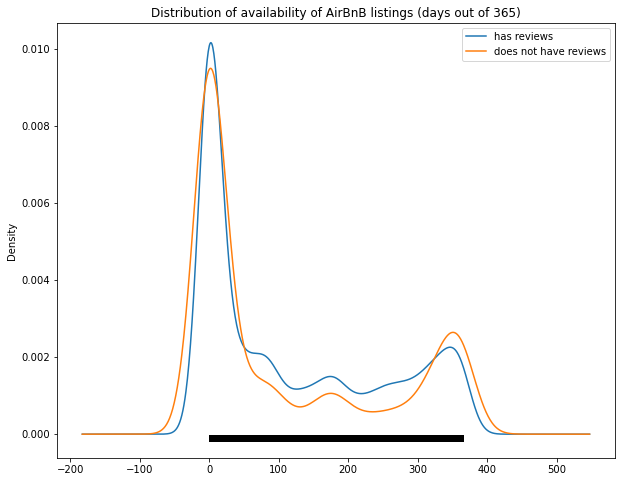

In [21]:
plot_distribution(eda_data, 'availability_365', title = 'Distribution of availability of AirBnB listings (days out of 365)')

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely. If they are not available now, have they ever been available? If any of them have reviews, it would imply that they have been available in the past.

In [22]:
eda_data[eda_data['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

,availability_365
has_reviews,
0,3882
1,10071


Many of the listings that are unavailable still have reviews. This suggests that at the time of the review(s), their availability was greater than 0. Going forward, we should bear in mind that the availability of the listings changes over time and we only have access to the value of availability at a single point in time. This might make the `availability_365` feature unreliable.

Make the data continuous by converting to the fraction of the year when the listing is available.

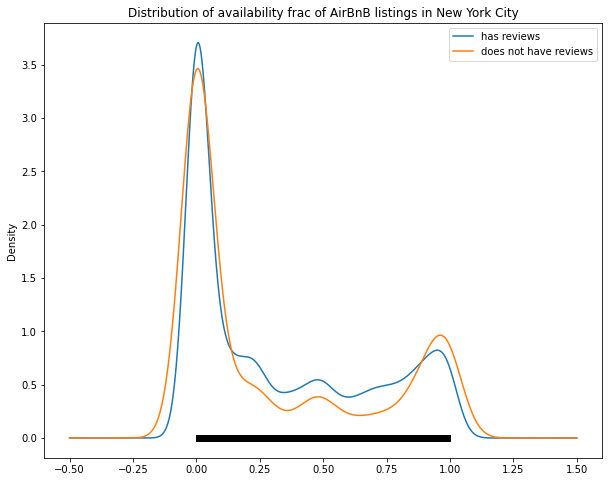

In [23]:
eda_data['availability_frac'] = eda_data['availability_365'] / 365
plot_distribution(eda_data, 'availability_frac')

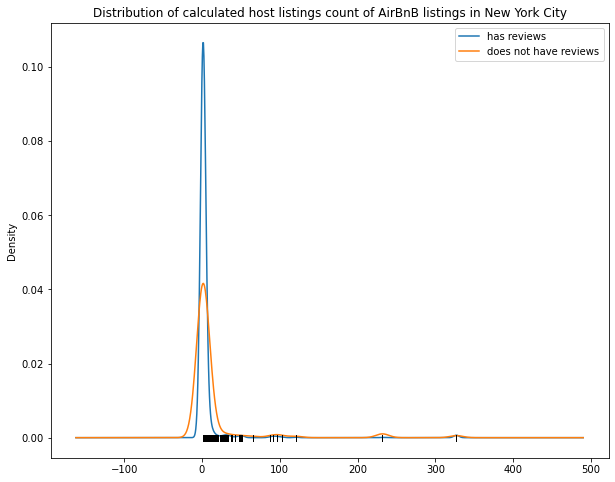

In [24]:
plot_distribution(eda_data, 'calculated_host_listings_count')

Again, this looks like a log normal distribution with some very large outliers.

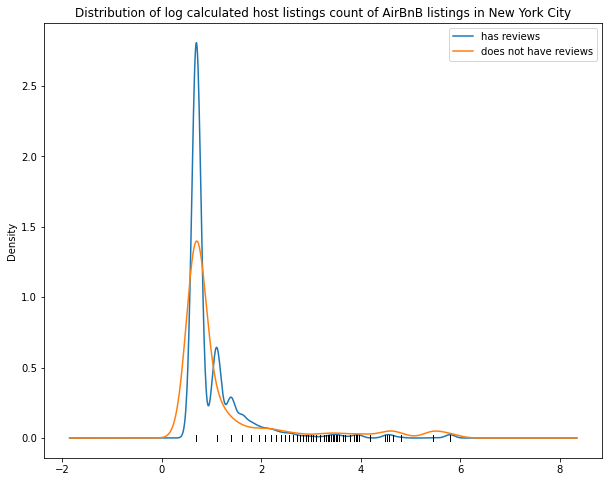

In [25]:
# since we are now performing log twice we should create a function that we will apply to the test and training data.
def transform_log_normal_variables(df: pd.DataFrame, columns_to_transform: List[str], drop = True) -> pd.DataFrame:
    new_df = df.copy()
    for col in columns_to_transform:
        new_column = 'log_' + col
        new_df[new_column] = new_df[col].apply(lambda x: np.log(x+1)) # prevent ln 0 errors
    if drop:
        new_df.drop(columns = columns_to_transform, inplace = True)
    return new_df

eda_data = transform_log_normal_variables(eda_data, ['calculated_host_listings_count'], drop = False)
plot_distribution(eda_data, 'log_calculated_host_listings_count')

On inspection it does not appear to be a log normal distribution. The data is bounded by 0 and has a long tail in the positive direction.

In [26]:
eda_data.drop(columns= ['log_calculated_host_listings_count'], inplace = True)

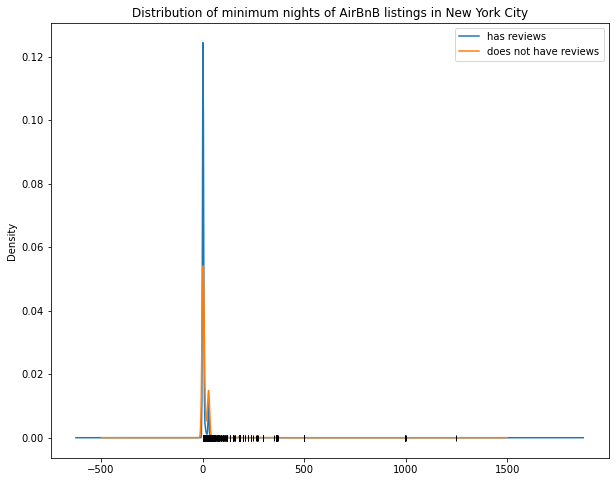

In [27]:
plot_distribution(eda_data, 'minimum_nights')

This variable also has some extreme outliers.

Minimum nights greater than a few month lean more towards tenancy than holiday stay.

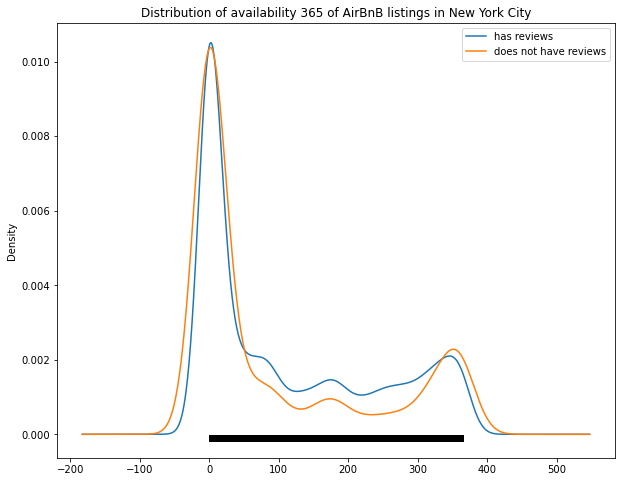

In [28]:
class OutlierRemover:
    def __init__(self, min_z_score = -3, max_z_score = 3):
        self.min_z_score = min_z_score
        self.max_z_score = max_z_score
        self.means_sds = {}
        self.list_of_columns = []
    def fit(self, data, list_of_columns = []):
        if len(list_of_columns)==0:
            list_of_columns = data.columns
        self.list_of_columns = list_of_columns
        for col in list_of_columns:
            mean = data[col].mean()
            sd = np.sqrt(data[col].var())
            self.means_sds[col] = (mean, sd)
    def calculate_z_score(self, value, col):
        return (value - self.means_sds[col][0])/self.means_sds[col][1]
    def transform(self, data):
        if len(self.means_sds.keys())==0:
            print("Transformer must be fit before transformation. Call .fit(data) or .fit_transform(data)")
            return
        for col in self.list_of_columns:
            z_scores = data[col].apply(self.calculate_z_score, col=col)
            keep = (z_scores>self.min_z_score)&(z_scores<self.max_z_score)
            data = data[keep]
        return data
    def fit_transform(self, data, list_of_cols = []):
        self.fit(data, list_of_cols)
        return self.transform(data)
    
o_r = OutlierRemover()

numerical_features = eda_data.select_dtypes('number')
eda_data[numerical_features.columns] = o_r.fit_transform(numerical_features)
plot_distribution(eda_data, 'availability_365')

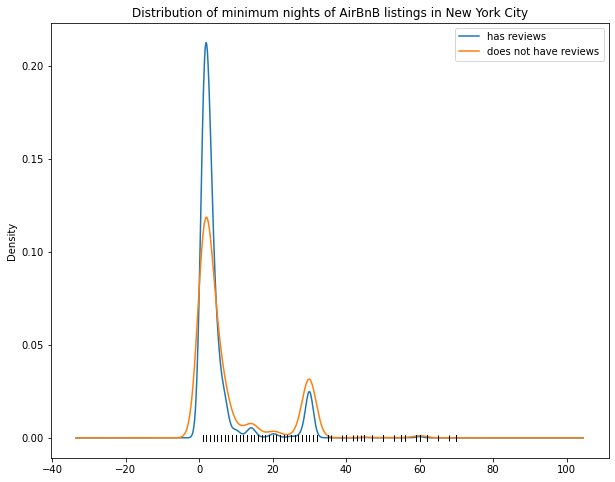

In [29]:
plot_distribution(eda_data, 'minimum_nights')

### Categorical features

In [30]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac
32645,Brooklyn,Williamsburg,40.71577,-73.95530,Entire home/apt,295.0,3.0,1.0,1.0,1.0,5.690359,0.002740
23615,Manhattan,Washington Heights,40.84917,-73.94048,Private room,70.0,2.0,1.0,0.0,1.0,4.262680,0.000000
31183,Brooklyn,Bedford-Stuyvesant,40.68993,-73.95947,Private room,58.0,2.0,2.0,0.0,0.0,4.077537,0.000000
29260,Brooklyn,Bedford-Stuyvesant,40.68427,-73.93118,Entire home/apt,75.0,3.0,1.0,267.0,1.0,4.330733,0.731507
7275,Queens,Woodside,40.74705,-73.89564,Private room,38.0,5.0,1.0,0.0,1.0,3.663562,0.000000


<AxesSubplot:xlabel='room_type', ylabel='log_price'>

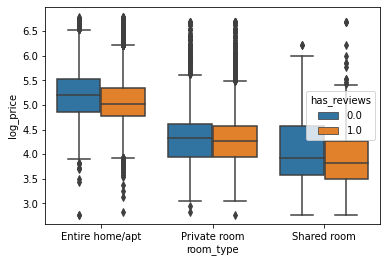

In [31]:
sns.boxplot(data = eda_data, x = 'room_type', y = 'log_price', hue = 'has_reviews')

In [32]:
eda_data['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='log_price'>

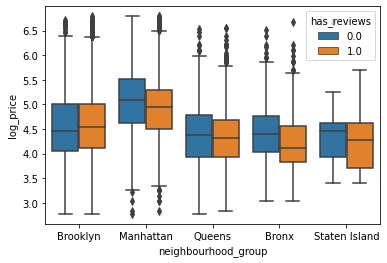

In [33]:
sns.boxplot(data = eda_data, x = 'neighbourhood_group', y = 'log_price', hue = 'has_reviews')

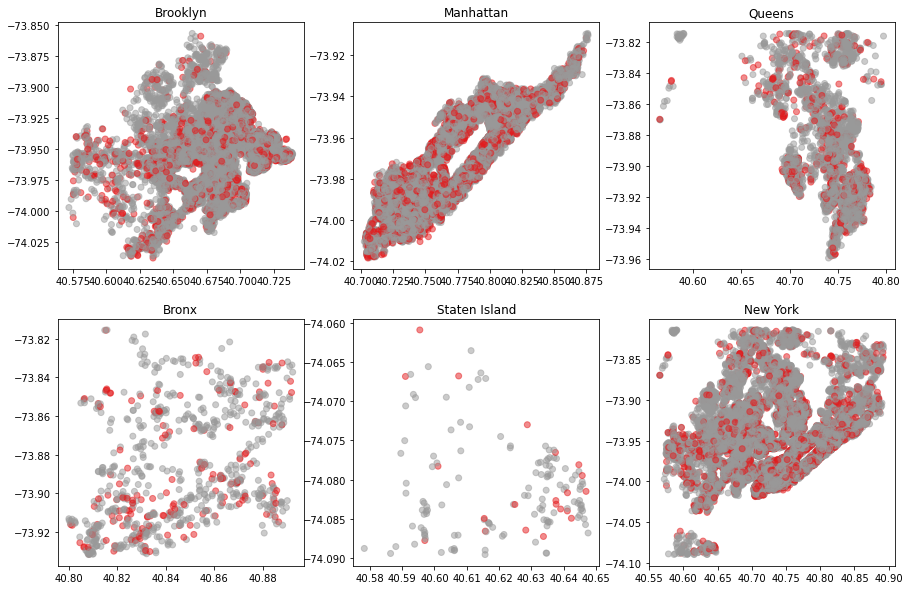

In [34]:
fig, axs = plt.subplots(ncols = 3, nrows =2, figsize = (15,10))

neighs = eda_data['neighbourhood_group'].unique().tolist() + ['New York']
i = 0

for row in range(2):
    for col in range(3):
        if i < 5:
            neigh_dat = eda_data[eda_data['neighbourhood_group']==neighs[i]]
        else:
            neigh_dat = eda_data
        axs[row, col].scatter(x = neigh_dat['latitude'], y = neigh_dat['longitude'], 
                              c = neigh_dat['has_reviews'], alpha = 0.5, cmap = 'Set1')
        axs[row, col].set_title(neighs[i])
        i+=1

Even though one could argue that entire home is "better" than private room, assigning the room types values 1, 2, and 3 would assume that they are equally spaced. These  values will be one hot encoded instead.
For now, neighbourhood and neighbourhood group will **not** be used - the assumption is that the information about vicinity is adequately encoded by latitude and longitude. They can be brought back in later if needed.



In [35]:
ohe = OneHotEncoder()

def adjust_column_headers(col: str):
    return col.lower().replace(' ', '_')

def one_hot_encode(df, col_to_encode, ohe: OneHotEncoder, fit = True, col_to_drop = None) -> pd.DataFrame:
    data_to_encode = df[[col_to_encode]]
    if fit:
        ohe_data_array = ohe.fit_transform(data_to_encode).toarray()
    else:
        ohe_data_array = ohe.transform(data_to_encode).toarray()
    column_names = ohe.get_feature_names([col_to_encode])
    column_names = [adjust_column_headers(col) for col in column_names]
    col_to_drop = col_to_encode + '_' + adjust_column_headers(col_to_drop)
    ohe_data = pd.DataFrame(data = ohe_data_array, columns = column_names)
    if col_to_drop is None:
        cols_to_drop = [col_to_encode]
    else:
        cols_to_drop = [col_to_encode, col_to_drop]
    new_df = pd.concat([df.reset_index(drop = True), ohe_data], axis = 1).drop(columns = cols_to_drop)
    return new_df
    
eda_data = one_hot_encode(eda_data, 'room_type', ohe, col_to_drop = 'Shared room')
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room
0,Brooklyn,Williamsburg,40.71577,-73.95530,295.0,3.0,1.0,1.0,1.0,5.690359,0.002740,1.0,0.0
1,Manhattan,Washington Heights,40.84917,-73.94048,70.0,2.0,1.0,0.0,1.0,4.262680,0.000000,0.0,1.0
2,Brooklyn,Bedford-Stuyvesant,40.68993,-73.95947,58.0,2.0,2.0,0.0,0.0,4.077537,0.000000,0.0,1.0
3,Brooklyn,Bedford-Stuyvesant,40.68427,-73.93118,75.0,3.0,1.0,267.0,1.0,4.330733,0.731507,1.0,0.0
4,Queens,Woodside,40.74705,-73.89564,38.0,5.0,1.0,0.0,1.0,3.663562,0.000000,0.0,1.0


Before attempting to visualise two or three variables together, the data will be scaled.

In [38]:
ms = MinMaxScaler()
ss = StandardScaler()

def scale_data(df: pd.DataFrame, columns_to_transform: List[str], scaler, fit = True, drop = True) -> pd.DataFrame:
    data_to_transform = df.copy()[columns_to_transform]
    scaled_data = scaler.fit_transform(data_to_transform)
    new_cols = ['scaled_' + col for col in columns_to_transform]
    df[new_cols] = scaled_data
    if drop:
        df.drop(columns=columns_to_transform, inplace = True)
    return df

eda_data_scaled = scale_data(eda_data,['minimum_nights', 'calculated_host_listings_count'], ms, drop = False)
eda_data_scaled = scale_data(eda_data_scaled, ['longitude', 'latitude'], ss, drop = False)
eda_data_scaled.sample(12)

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude
11697,Manhattan,East Village,40.72691,-73.98423,149.0,2.0,1.0,0.0,1.0,5.010635,0.000000,1.0,0.0,0.014493,0.000000,-0.809546,-0.057007
21887,Manhattan,Hell's Kitchen,40.76838,-73.98723,95.0,1.0,5.0,21.0,1.0,4.564348,0.057534,0.0,0.0,0.000000,0.039216,-0.892067,0.714372
6743,Queens,East Elmhurst,40.77009,-73.87708,32.0,1.0,5.0,161.0,1.0,3.496508,0.441096,0.0,1.0,0.000000,0.039216,2.137817,0.746180
24389,Brooklyn,Williamsburg,40.71383,-73.96289,298.0,3.0,1.0,4.0,1.0,5.700444,0.010959,1.0,0.0,0.028986,0.000000,-0.222549,-0.300307
27513,Brooklyn,Fort Greene,40.69011,-73.98053,225.0,1.0,1.0,0.0,0.0,5.420535,0.000000,1.0,0.0,0.000000,0.000000,-0.707770,-0.741520
2973,Queens,Springfield Gardens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN
26762,Brooklyn,Crown Heights,40.66758,-73.95033,50.0,1.0,1.0,0.0,0.0,3.931826,0.000000,0.0,1.0,0.000000,0.000000,0.122938,-1.160599
34001,Brooklyn,Bushwick,40.70312,-73.92071,75.0,2.0,1.0,76.0,1.0,4.330733,0.208219,0.0,1.0,0.014493,0.000000,0.937691,-0.499523
1337,Queens,Ozone Park,40.67743,-73.84941,65.0,1.0,4.0,334.0,1.0,4.189655,0.915068,0.0,1.0,0.000000,0.029412,2.898932,-0.977380
31579,Manhattan,Hell's Kitchen,40.75893,-73.99014,140.0,3.0,1.0,157.0,1.0,4.948760,0.430137,1.0,0.0,0.028986,0.000000,-0.972112,0.538594


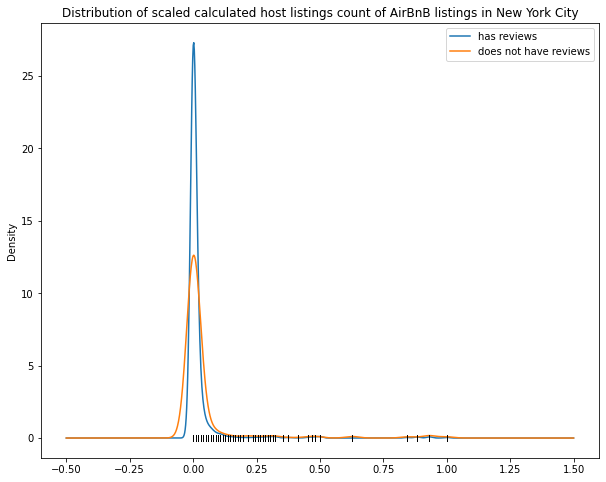

In [39]:
plot_distribution(eda_data_scaled, 'scaled_calculated_host_listings_count')

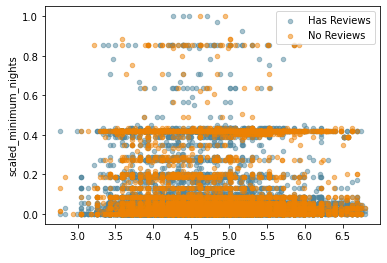

In [40]:
def plot_two_variables(df, var1, var2):
    ax = df[df['has_reviews']==1].plot(kind = 'scatter', x = var1, y = var2, 
                                  label = 'Has Reviews', color = '#50869D', 
                                  alpha = 0.5)
    df[df['has_reviews']==0].plot(kind = 'scatter',x = var1, y = var2, 
                                       label = 'No Reviews', color = '#ED8103',
                                       alpha = 0.5, ax=ax)
    ax.legend();
    
plot_two_variables(eda_data, 'log_price', 'scaled_minimum_nights')

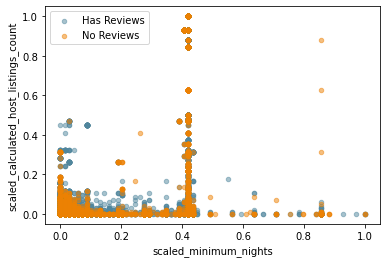

In [41]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'scaled_calculated_host_listings_count')

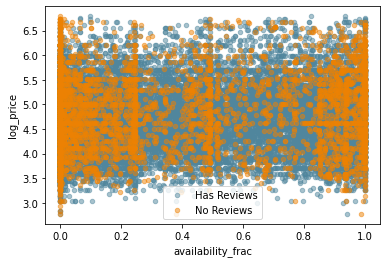

In [42]:
plot_two_variables(eda_data, 'availability_frac', 'log_price')

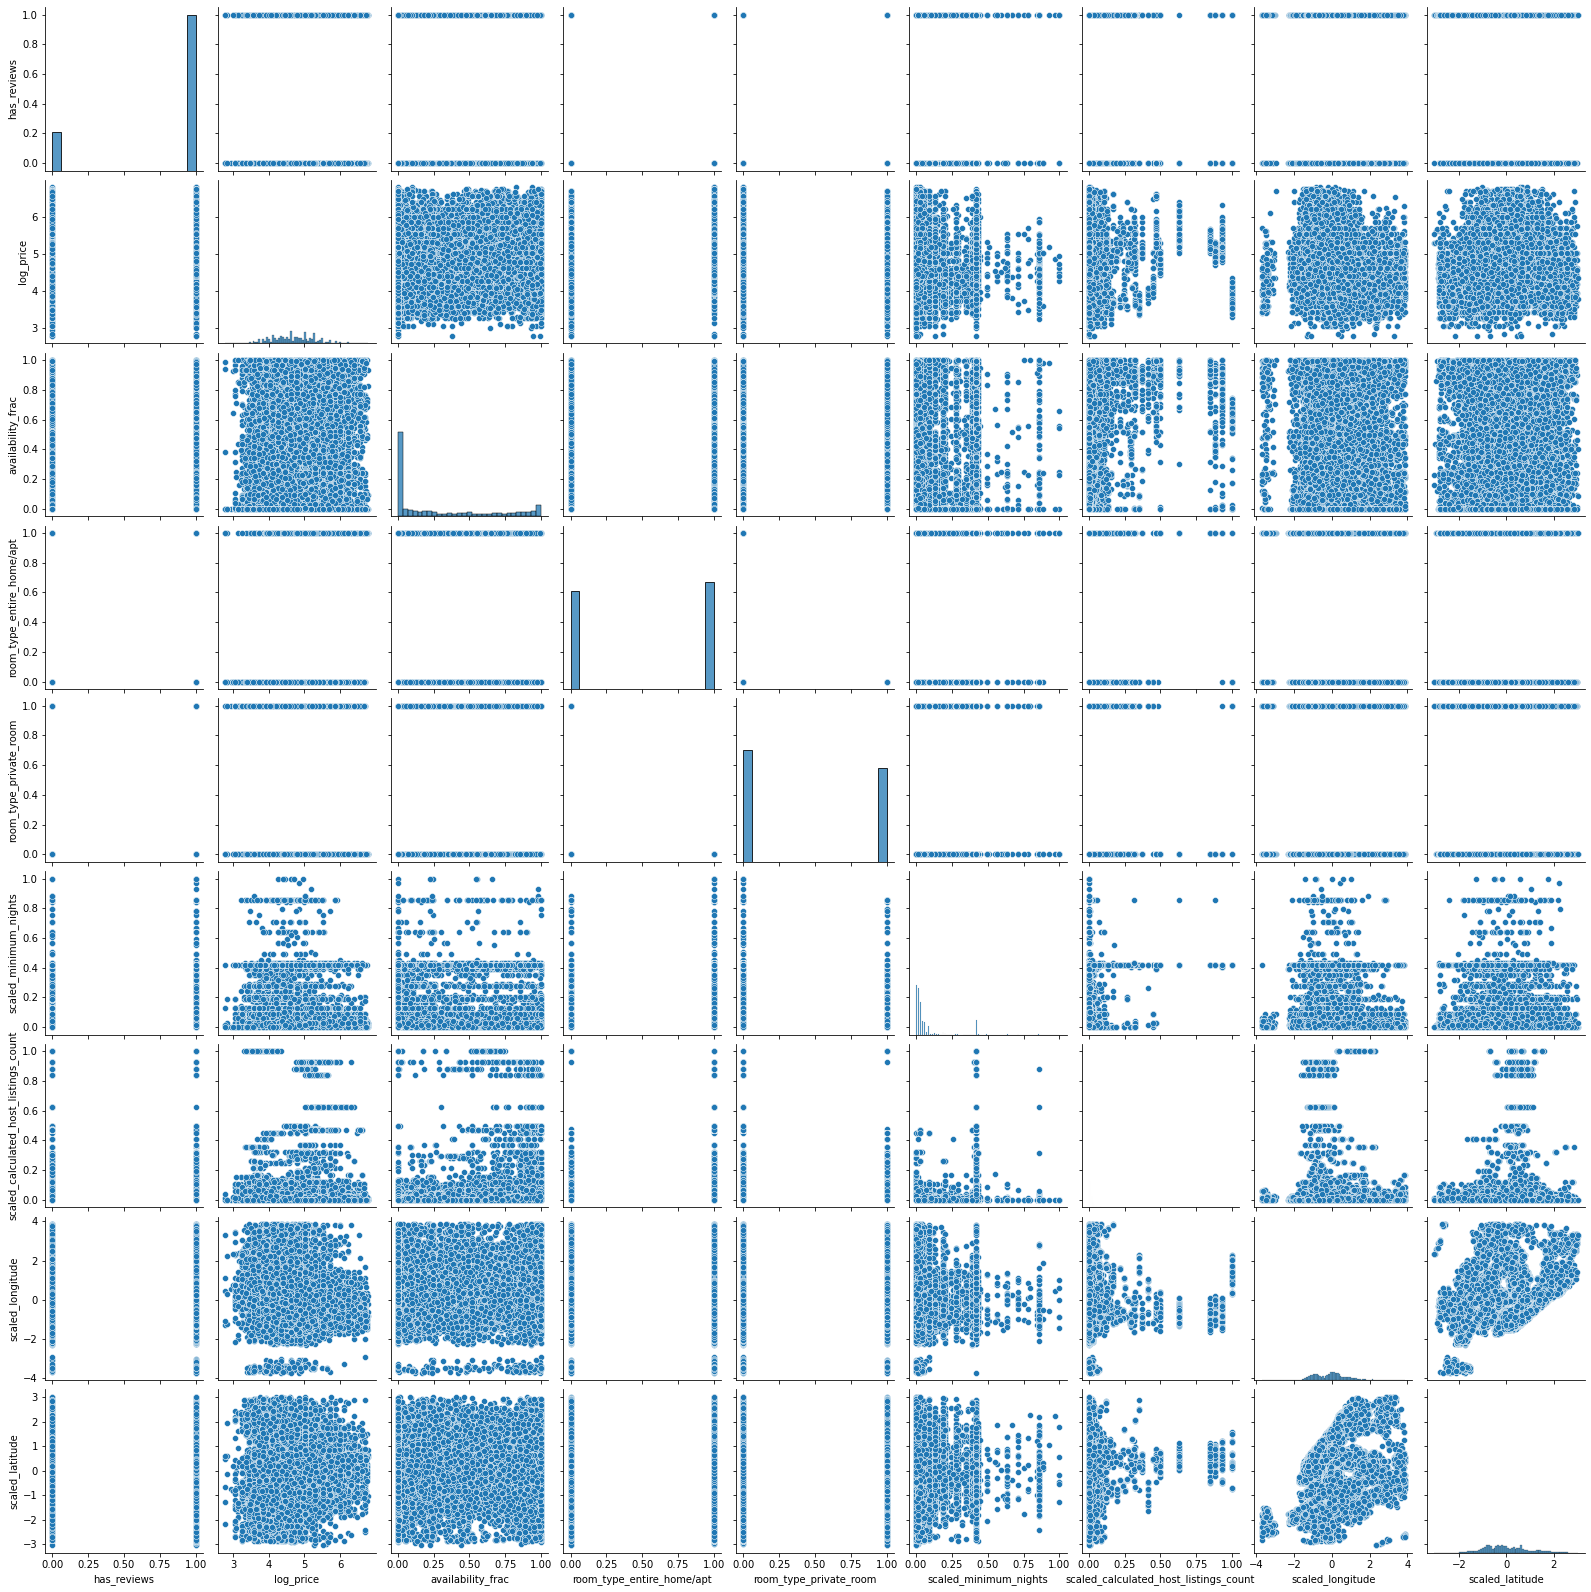

In [43]:
sns.pairplot(eda_data[['has_reviews', 'log_price', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude']])

There are a number of measures that have not been taken that will be tested to see if they improve model accuracy after the first round of model training:
   
- downsampling listings with reviews

For now, all of the preprocessing steps above will be repeated on X_train and X_test (transformers will be fit only on X_test).
    

In [44]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude
0,Brooklyn,Williamsburg,40.71577,-73.95530,295.0,3.0,1.0,1.0,1.0,5.690359,0.002740,1.0,0.0,0.028986,0.000000,-0.013772,-0.264221
1,Manhattan,Washington Heights,40.84917,-73.94048,70.0,2.0,1.0,0.0,1.0,4.262680,0.000000,0.0,1.0,0.014493,0.000000,0.393880,2.217139
2,Brooklyn,Bedford-Stuyvesant,40.68993,-73.95947,58.0,2.0,2.0,0.0,0.0,4.077537,0.000000,0.0,1.0,0.014493,0.009804,-0.128475,-0.744868
3,Brooklyn,Bedford-Stuyvesant,40.68427,-73.93118,75.0,3.0,1.0,267.0,1.0,4.330733,0.731507,1.0,0.0,0.028986,0.000000,0.649694,-0.850150
4,Queens,Woodside,40.74705,-73.89564,38.0,5.0,1.0,0.0,1.0,3.663562,0.000000,0.0,1.0,0.057971,0.000000,1.627289,0.317615


In [68]:
one_hot_encoder = OneHotEncoder()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
outlier_remover = OutlierRemover()

def apply_transformations(df, fit = True):
    new_df = df.copy()
    new_df['availability_frac'] = new_df['availability_365'] / 365
    new_df.drop(columns = ['availability_365'], inplace = True)
    numeric_features = new_df.select_dtypes('number').columns
    if fit:
        outlier_removed_df = outlier_remover.fit_transform(new_df, numeric_features)
    else:
        outlier_removed_df = outlier_remover.transform(new_df)
    log_df = transform_log_normal_variables(outlier_removed_df, ['price'], drop = True)
    ohe_df = one_hot_encode(log_df, 'room_type', one_hot_encoder, col_to_drop = 'Shared room', fit = fit)
    minmax_scaled_df = scale_data(ohe_df, ['minimum_nights', 'calculated_host_listings_count'], 
                                  minmax_scaler, drop = True, fit = fit)
    standard_scaled_df = scale_data(minmax_scaled_df, ['longitude', 'latitude', 'log_price'],
                                   standard_scaler, drop = True, fit = fit)
    return standard_scaled_df

raw_train = apply_transformations(raw_train, fit = True)
raw_test = apply_transformations(raw_test, fit = False)
raw_train.head()

,neighbourhood_group,neighbourhood,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
0,Brooklyn,Williamsburg,1,0.002740,1.0,0.0,0.028986,0.000000,-0.014056,-0.264219,1.496879
1,Manhattan,Washington Heights,1,0.000000,0.0,1.0,0.014493,0.000000,0.393585,2.217261,-0.694642
2,Brooklyn,Bedford-Stuyvesant,0,0.000000,0.0,1.0,0.014493,0.009804,-0.128756,-0.744890,-0.978840
3,Brooklyn,Bedford-Stuyvesant,1,0.731507,1.0,0.0,0.028986,0.000000,0.649392,-0.850176,-0.590178
4,Queens,Woodside,1,0.000000,0.0,1.0,0.057971,0.000000,1.626959,0.317645,-1.614302


In [69]:
raw_train.describe()

,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
count,36983.000000,36983.000000,36983.000000,36983.000000,36983.000000,36983.000000,3.698300e+04,3.698300e+04,3.698300e+04
mean,0.802098,0.295074,0.513966,0.462158,0.069179,0.025866,1.183784e-14,3.434928e-14,2.106041e-16
std,0.398423,0.354618,0.499812,0.498573,0.126913,0.108363,1.000014e+00,1.000014e+00,1.000014e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.707301e+00,-3.060257e+00,-7.237952e+00
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.597462e-01,-7.342871e-01,-7.164156e-01
50%,1.000000,0.101370,1.000000,0.000000,0.028986,0.000000,-2.560827e-02,-1.183813e-01,-7.946739e-02
75%,1.000000,0.578082,1.000000,1.000000,0.057971,0.009804,4.640004e-01,6.302483e-01,6.988581e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.864855e+00,3.022347e+00,3.188451e+00


In [72]:
len(raw_train)

36983

## Feature Selection

For now, we will ignore the neighbourhoods and neighbourhood groups assuming that the longitude and latitude information is enough for listings in the same neighbourhood to be considered similar.

This leaves us with the following columns:

In [71]:
cols_to_drop = ['neighbourhood_group', 'neighbourhood']

raw_train.drop(columns = cols_to_drop, inplace = True)
raw_test.drop(columns = cols_to_drop, inplace = True)
raw_train.columns

Index(['has_reviews', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude', 'scaled_log_price'],
      dtype='object')

In [76]:
y_train = raw_train.pop('has_reviews')
X_train = raw_train


num_features = 4

feature_selector = SelectKBest(score_func = f_classif, k = num_features)

feature_selector.fit(X=X_train, y = y_train)

selected_columns = feature_selector.get_support()

X_train_kbest = X_train[X_train.columns[selected_columns]]


#X_test_kbest = X_test[X_train_kbest.columns]

X_train_kbest.head()

,availability_frac,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_log_price
0,0.002740,0.028986,0.000000,1.496879
1,0.000000,0.014493,0.000000,-0.694642
2,0.000000,0.014493,0.009804,-0.978840
3,0.731507,0.028986,0.000000,-0.590178
4,0.000000,0.057971,0.000000,-1.614302


In [77]:
print(f"Selected columns are {', '.join(X_train_kbest.columns.tolist())}.")

Selected columns are availability_frac, scaled_minimum_nights, scaled_calculated_host_listings_count, scaled_log_price.


In [78]:
y_test = raw_test.pop('has_reviews')
X_test = raw_test

X_test_kbest = X_test[X_train_kbest.columns]
X_test_kbest.head()

,availability_frac,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_log_price
0,0.517808,0.028986,0.0,-0.317106
1,0.200000,0.289855,0.0,-1.960548
2,0.000000,0.014493,0.0,0.139281
3,0.082192,0.014493,0.0,0.914151
4,0.076712,0.000000,0.0,0.672599


In [79]:
# Convert X_train, X_test, y_train, and y_test to numpy

X_train_np, X_test_np, y_train_np, y_test_np =  [df.to_numpy() for df in [X_train_kbest, X_test_kbest, y_train, y_test]]

y_train_np.shape

(36983,)

## Logistic Regression


In [80]:
lr = LogisticRegression(C = 1, class_weight = 'balanced', random_state = 42)

lr.fit(X_train_np, y_train_np)

y_pred = lr.predict(X_test_np)

f1_score(y_test, y_pred, average = 'macro')

0.5236410588090598

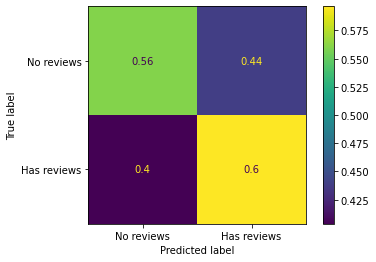

In [81]:
target_names = ["No reviews", "Has reviews"]

plot_confusion_matrix(lr, X_test_np, y_test_np, normalize = 'true', display_labels = target_names)

In [82]:
classif_report = classification_report(y_test_np, y_pred, target_names=target_names)
print(classif_report)

              precision    recall  f1-score   support

  No reviews       0.25      0.56      0.35      1797
 Has reviews       0.85      0.60      0.70      7465

    accuracy                           0.59      9262
   macro avg       0.55      0.58      0.52      9262
weighted avg       0.73      0.59      0.63      9262



In [85]:
# try to tune the algorithm before comparing to a decision tree

parameters = {"solver":["liblinear", "newton-cg"], "C":[0.1, 1, 10, 100, 1000]}

logistic_regression_model = LogisticRegression(class_weight = 'balanced')

K = 5 # number of folds

optimised_lr = GridSearchCV(estimator = logistic_regression_model,
                              param_grid = parameters,
                              scoring = 'f1_macro')

optimised_lr.fit(X_train_np, y_train_np)

print("Best parameters:\n", optimised_lr.best_params_)

y_pred = optimised_lr.predict(X_test_np)
print("\nMacro f1 score:\t", f1_score(y_pred, y_test_np, average ='macro'))

Best parameters:
 {'C': 100, 'solver': 'liblinear'}

Macro f1 score:	 0.5236331326125717


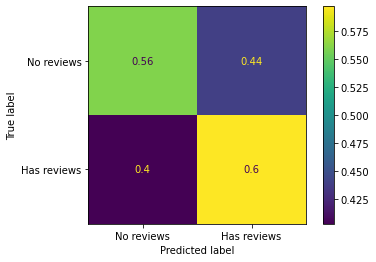

In [86]:
plot_confusion_matrix(optimised_lr, X_test_np, y_test_np, normalize = 'true', display_labels = target_names)

## Support Vector Machine



In [89]:
svm = SVC(kernel = 'rbf')
svm.fit(X_train_np, y_train_np)

y_pred = svm.predict(X_test_np)
print("\nMacro f1 score:\t", f1_score(y_pred, y_test_np, average ='macro'))


Macro f1 score:	 0.46984555526711347
